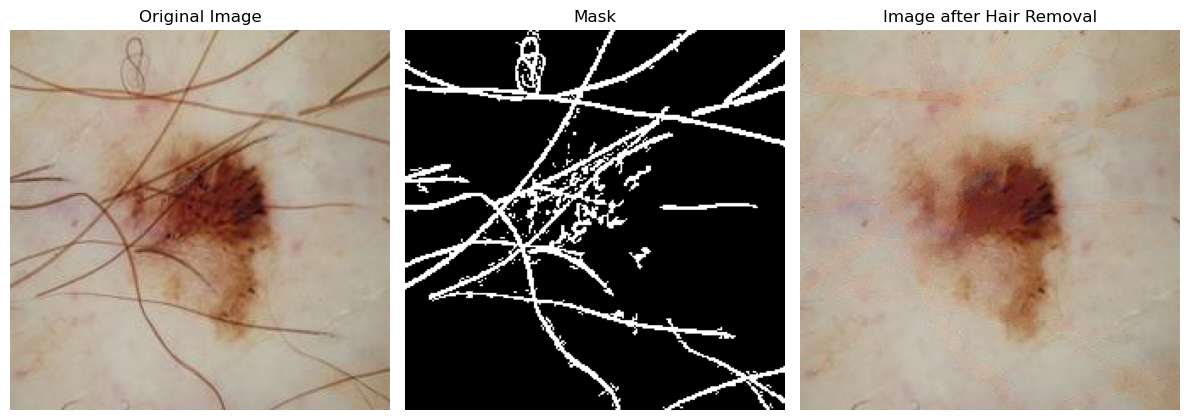

In [270]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


image = cv2.imread('data/train/Malignant/513.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
_, mask1 = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(mask1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for contour in contours:
    if cv2.contourArea(contour) < 30:  
        cv2.drawContours(mask1, [contour], -1, 0, -1)


inverse_mask1 = cv2.bitwise_not(mask1)
result_image = cv2.bitwise_and(image, image, mask=inverse_mask1)

inpainted_image = cv2.inpaint(result_image, mask1, inpaintRadius=3, flags=cv2.INPAINT_TELEA)


plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Mask')
plt.imshow(mask1, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Image after Hair Removal')
plt.imshow(cv2.cvtColor(inpainted_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import torch
import cv2
from matplotlib import pyplot as plt

# Clone the YOLOv5 repository
# !git clone https://github.com/ultralytics/yolov5  # clone

%cd yolov5

# # Install the required dependencies
# !pip install -qr requirements.txt  # install

import torch
import utils



# Load and run image through the YOLOv5 classification model
!python classify/predict.py --weights yolov5s-cls.pt --img 224 --source '2.jpg'


In [ ]:
%cd ..

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Load CSV
csv_path = 'dataset.csv'  # Change this to your CSV file path
data = pd.read_csv(csv_path)

# Ensure the data exists
for path in data['Path']:
    if not os.path.exists(path):
        raise FileNotFoundError(f"File {path} does not exist.")

# Split data into train and validation sets if necessary
train_data = data[data['Split'] == 'Train']
val_data = data[data['Split'] == 'Valid']

# Save the data splits in separate files
train_data[['Path', 'Label']].to_csv('train.txt', index=False, header=False)
val_data[['Path', 'Label']].to_csv('val.txt', index=False, header=False)

# Create the YAML file for YOLOv5
yaml_content = f"""
train: {os.path.abspath('train.txt')}
val: {os.path.abspath('val.txt')}
nc: {data['Label'].nunique()}
names: ['Benign', 'Malignant']
"""

with open('data.yaml', 'w') as yaml_file:
    yaml_file.write(yaml_content)


In [ ]:
# %cd yolov5
!python classify/train.py --model yolov5s-cls.pt --data data/data1 --epochs 100 --img 224 --cache



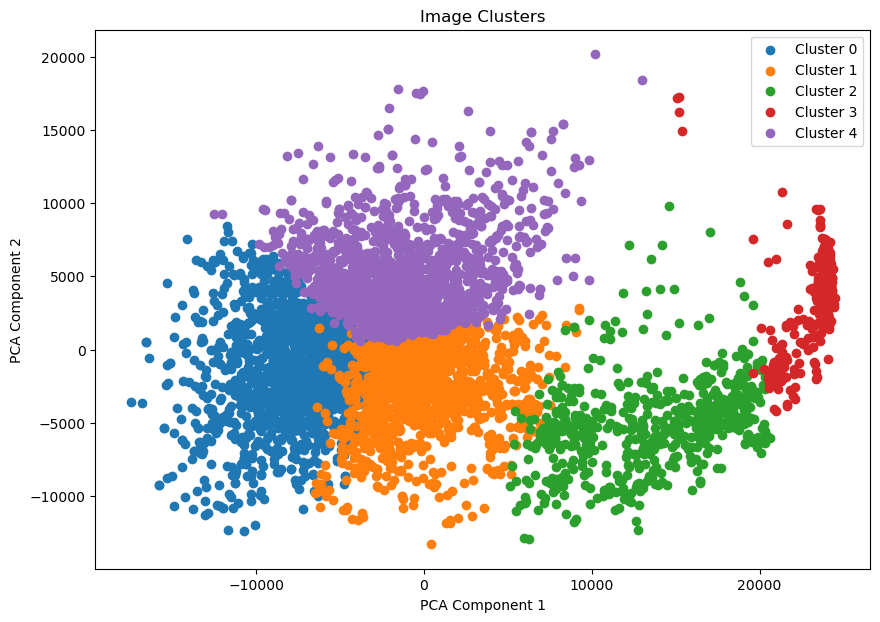

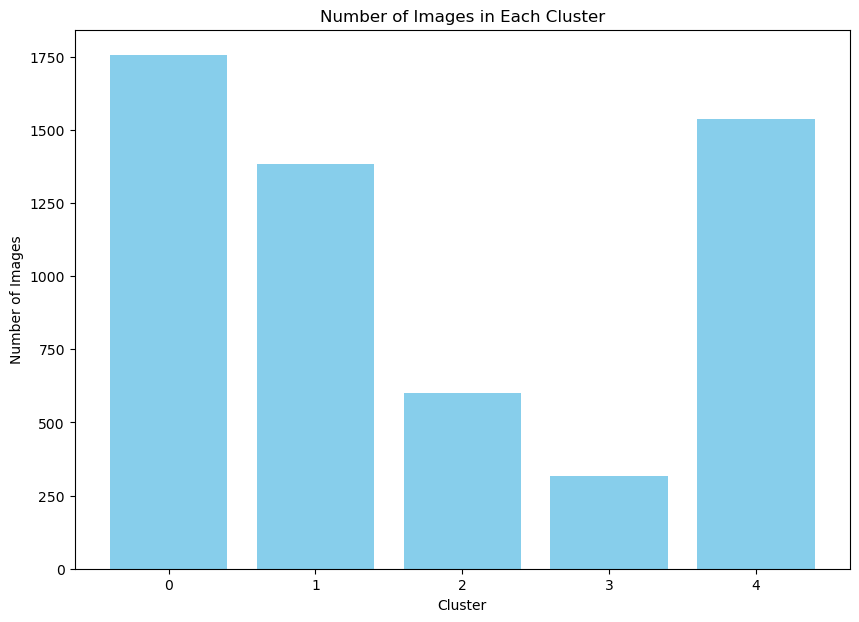

In [6]:
import os
import shutil
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

def load_images(image_folder):
    image_files = [os.path.join(image_folder, file) for file in os.listdir(image_folder) if file.endswith('.jpg')]
    if not image_files:
        raise ValueError(f"No image files found in folder: {image_folder}")
    
    images = [Image.open(file).resize((128, 128)) for file in image_files]
    image_data = np.array([np.array(image).flatten() for image in images])
    if image_data.size == 0:
        raise ValueError(f"Loaded image data is empty for folder: {image_folder}")
    
    return image_files, image_data

# Path to the image folder
image_folder = '/home/cloudcorn/sameerah/my_exam/data1/train/Malignant'
try:
    image_files, image_data = load_images(image_folder)
except ValueError as e:
    print(e)
    exit()

# Set number of clusters
n_clusters = 5

# Perform PCA for dimensionality reduction
pca = PCA(n_components=50)
image_data_pca = pca.fit_transform(image_data)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(image_data_pca)

# Create output directories for clusters
output_dir = 'train/malignant_clusters'
os.makedirs(output_dir, exist_ok=True)
cluster_dirs = [os.path.join(output_dir, f'cluster_{i}') for i in range(n_clusters)]
for dir in cluster_dirs:
    os.makedirs(dir, exist_ok=True)

# Move images to corresponding cluster directories
for cluster_idx, image_file in zip(clusters, image_files):
    shutil.move(image_file, os.path.join(cluster_dirs[cluster_idx], os.path.basename(image_file)))

# Function to preprocess images and save without converting to grayscale
def preprocess_images(image_folder):
    for file in os.listdir(image_folder):
        if file.endswith('.jpg'):
            image_path = os.path.join(image_folder, file)
            image = Image.open(image_path)
            image.save(image_path)

# Preprocess images in each cluster directory
for dir in cluster_dirs:
    preprocess_images(dir)

# Plotting the clusters
plt.figure(figsize=(10, 7))
for i in range(n_clusters):
    cluster_data = image_data_pca[clusters == i]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {i}')
plt.title('Image Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

# Count of images in each cluster
cluster_counts = [len(os.listdir(dir)) for dir in cluster_dirs]
plt.figure(figsize=(10, 7))
plt.bar(range(n_clusters), cluster_counts, color='skyblue')
plt.title('Number of Images in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Images')
plt.show()


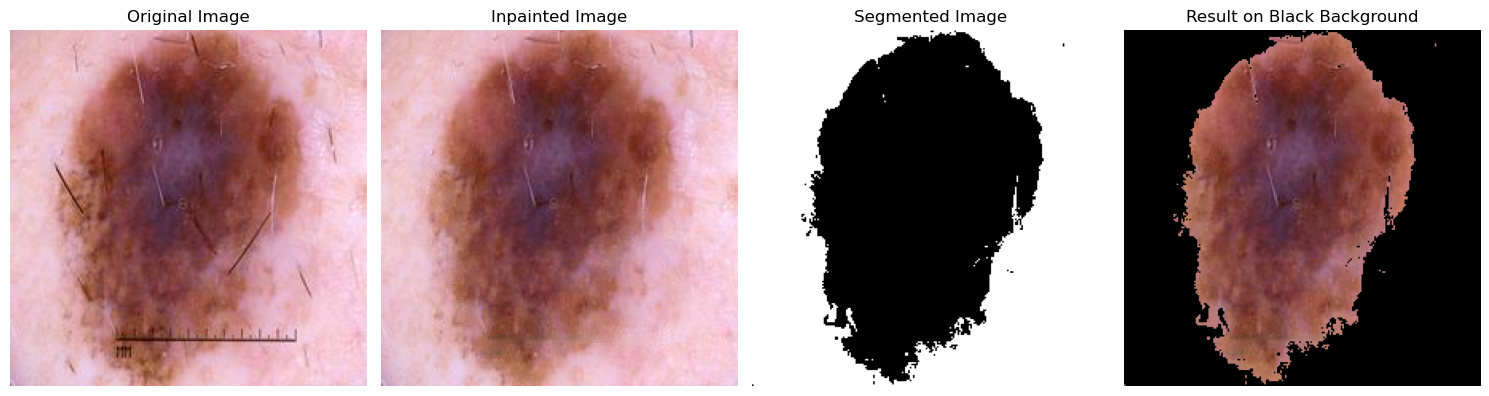

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as  plt

def remove_hair_and_segment(image_path):
    # Read the image
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Hair removal using blackhat morphological operation
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    _, mask1 = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)

    # Remove small contours
    contours, _ = cv2.findContours(mask1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        if cv2.contourArea(contour) < 20:
            cv2.drawContours(mask1, [contour], -1, 0, -1)

    # Create inverse mask for inpainting
    inverse_mask1 = cv2.bitwise_not(mask1)
    result_image = cv2.bitwise_and(image, image, mask=inverse_mask1)
    
    inpainted_image = cv2.inpaint(result_image, mask1, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
    ##################################
    
    _, segmented_image = cv2.threshold(cv2.cvtColor(inpainted_image, cv2.COLOR_BGR2GRAY), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

   
    black_background = np.zeros_like(image)

   
    black_background[segmented_image < 255] = inpainted_image[segmented_image < 255]

    
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 4, 1)
    plt.title('Original Image')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.title('Inpainted Image')
    plt.imshow(cv2.cvtColor(inpainted_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.title('Segmented Image')
    plt.imshow(segmented_image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.title('Result on Black Background')
    plt.imshow(cv2.cvtColor(black_background, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
remove_hair_and_segment('data/train/Malignant/68.jpg')


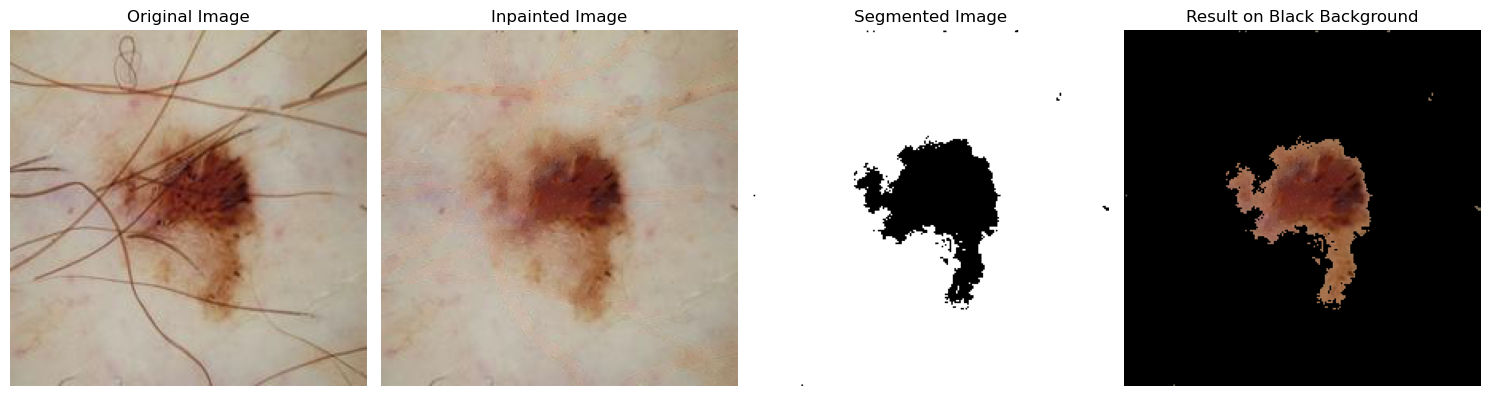

In [8]:
remove_hair_and_segment('data/train/Malignant/513.jpg')

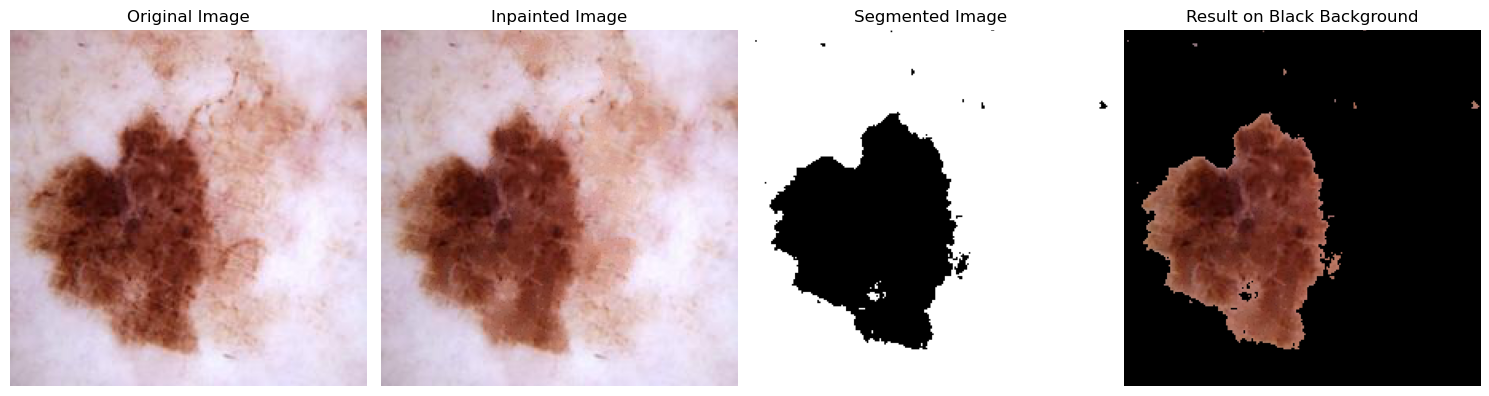

In [82]:
remove_hair_and_segment('/home/cloudcorn/sameerah/my_exam/train/malignant_clusters/cluster_0/50.jpg')

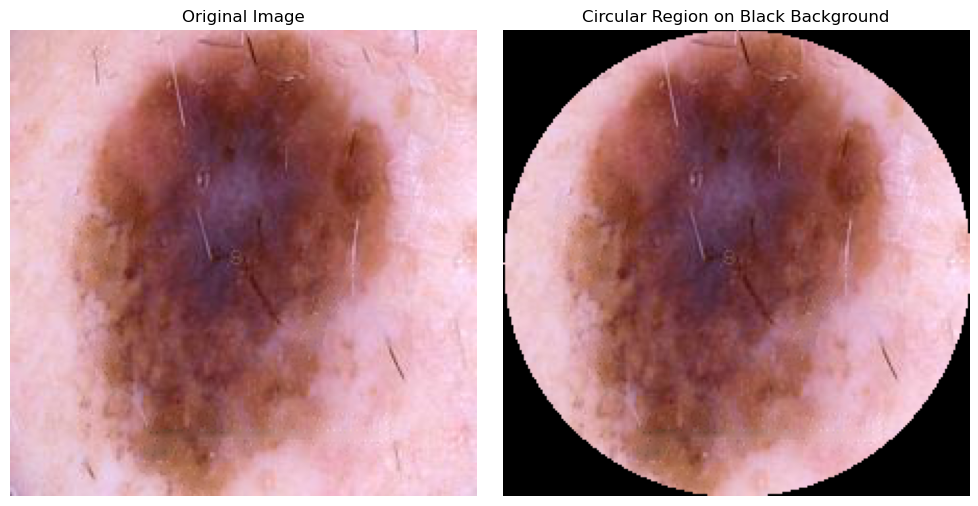

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def extract_circular_region(image_path):
    # Read the image
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    _, mask1 = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(mask1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        if cv2.contourArea(contour) < 50:  
            cv2.drawContours(mask1, [contour], -1, 0, -1)


    inverse_mask1 = cv2.bitwise_not(mask1)
    result_image = cv2.bitwise_and(image, image, mask=inverse_mask1)

    image = cv2.inpaint(result_image, mask1, inpaintRadius=3, flags=cv2.INPAINT_TELEA)    
    #################################################
    height, width = image.shape[:2]
    center_x, center_y = width // 2, height // 2
    radius = min(center_x, center_y)  # Radius of the circle

    
    mask = np.zeros((height, width), dtype="uint8")
    
    
    cv2.circle(mask, (center_x, center_y), radius, (255, 255, 255), -1)
    
   
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    
    
    black_background = np.zeros_like(image)

    
    black_background[mask == 255] = masked_image[mask == 255]

   
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Circular Region on Black Background')
    plt.imshow(cv2.cvtColor(black_background, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
extract_circular_region('data/train/Malignant/68.jpg')


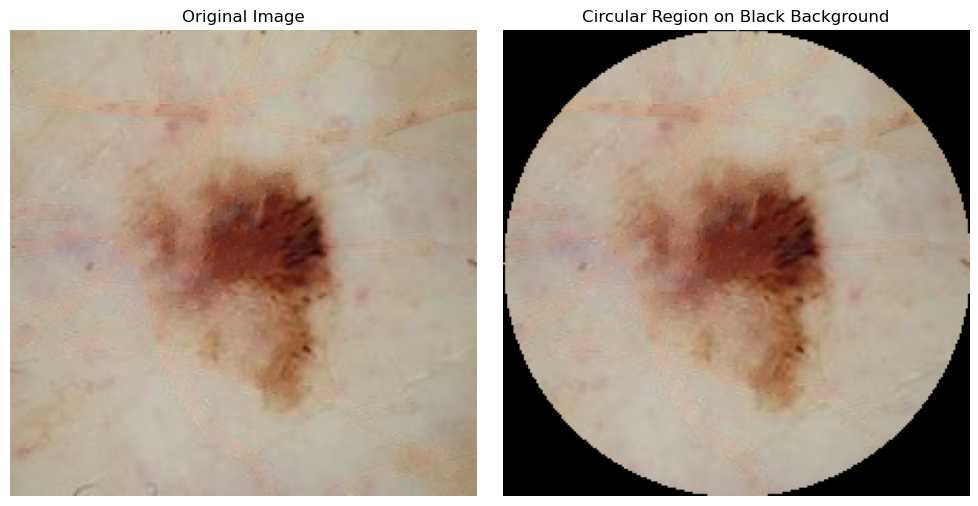

In [11]:
extract_circular_region('data/train/Malignant/513.jpg')

75 109


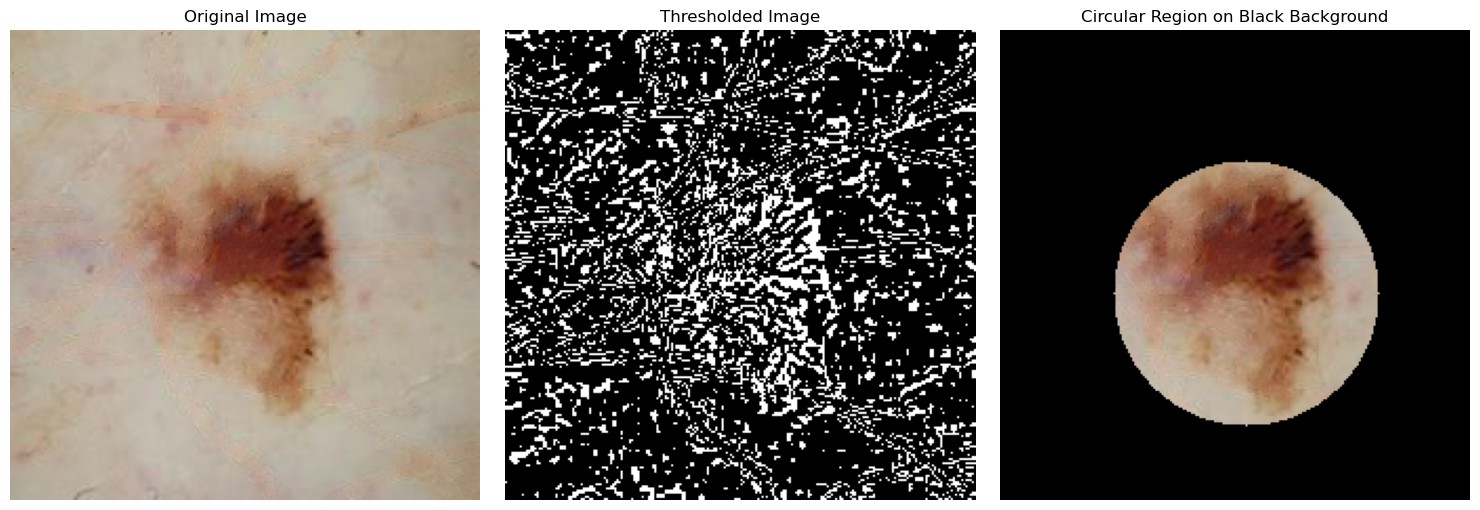

In [220]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def extract_circular_region(image_path):
    # Read the image
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    _, mask1 = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(mask1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        if cv2.contourArea(contour) < 50:  
            cv2.drawContours(mask1, [contour], -1, 0, -1)


    inverse_mask1 = cv2.bitwise_not(mask1)
    result_image = cv2.bitwise_and(image, image, mask=inverse_mask1)

    image = cv2.inpaint(result_image, mask1, inpaintRadius=3, flags=cv2.INPAINT_TELEA)        
    ###########################
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Otsu's thresholding
    _, segmented_image = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
   
   
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Find the largest contour and compute the bounding rectangle
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        center = (x + w // 2, y + h // 2)

      
        print(x,y)
        if x>100:
            scale_factor = 4
        else:
            scale_factor = 1.5
        radius = int(max(w, h) // 2 * scale_factor)

       
        mask = np.zeros_like(gray)
        cv2.circle(mask, center, radius, (255), thickness=-1)

        
        masked_image = cv2.bitwise_and(image, image, mask=mask)

        
        black_background = np.zeros_like(image)
        black_background[mask == 255] = masked_image[mask == 255]

        
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.title('Original Image')
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title('Thresholded Image')
        plt.imshow(thresh, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title('Circular Region on Black Background')
        plt.imshow(cv2.cvtColor(black_background, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.tight_layout()
        plt.show()



extract_circular_region('data/train/Malignant/513.jpg')


155 48


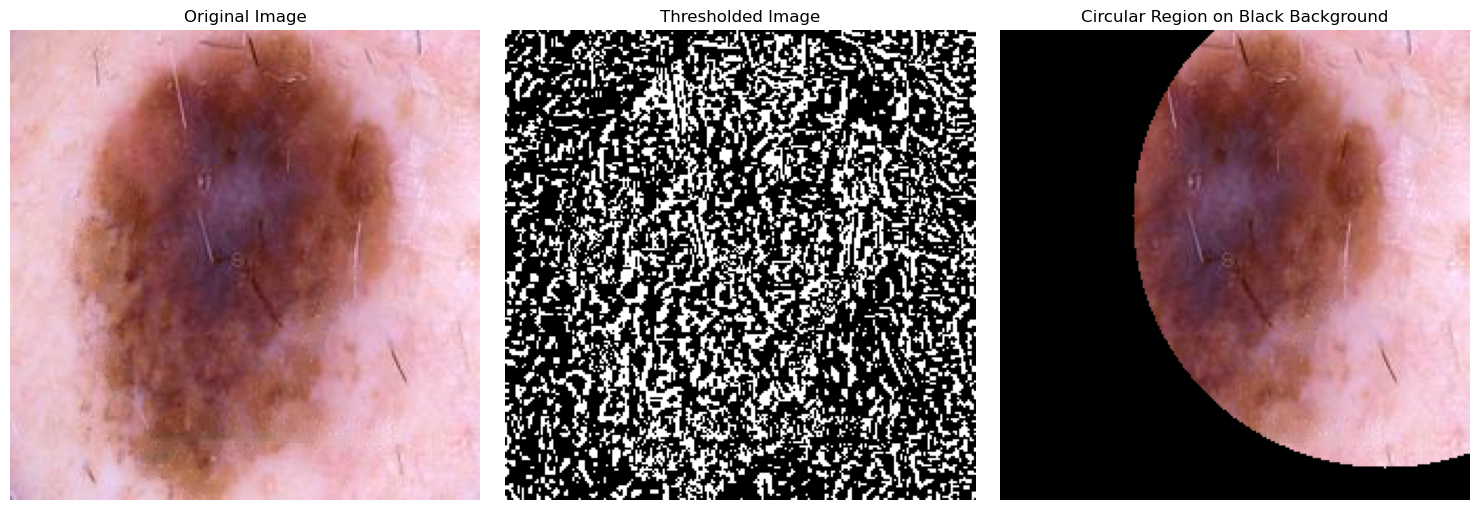

In [221]:
extract_circular_region('data/train/Malignant/68.jpg')

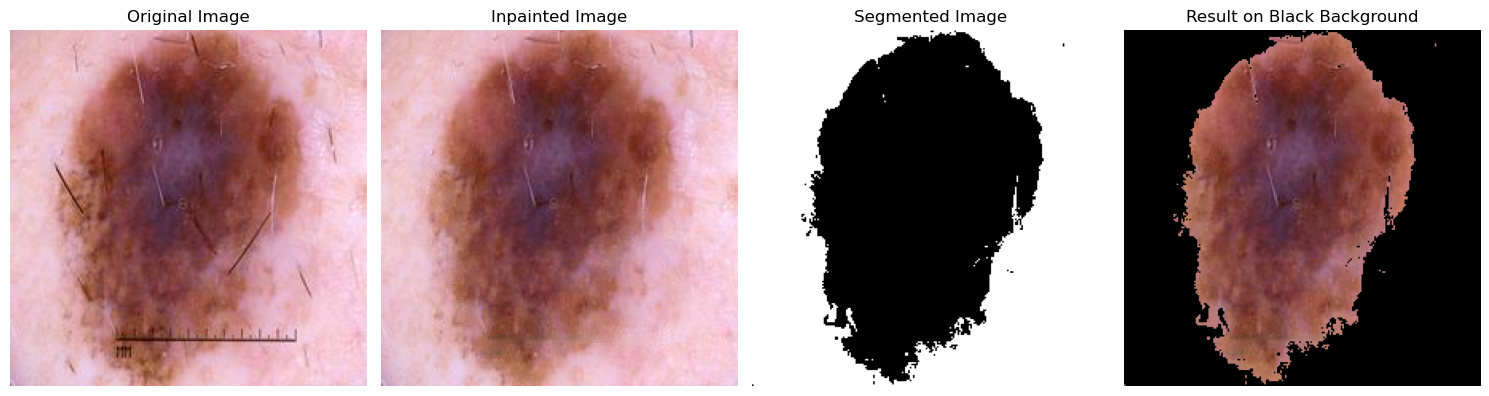

In [217]:
import cv2
import numpy as np
import matplotlib.pyplot as plt



def remove_hair_and_segment(image_path):
    
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    _, mask1 = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)

    
    contours, _ = cv2.findContours(mask1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        if cv2.contourArea(contour) < 20:
            cv2.drawContours(mask1, [contour], -1, 0, -1)

  
    inverse_mask1 = cv2.bitwise_not(mask1)
    result_image = cv2.bitwise_and(image, image, mask=inverse_mask1)
    
    inpainted_image = cv2.inpaint(result_image, mask1, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
    
  
    gray_inpainted = cv2.cvtColor(inpainted_image, cv2.COLOR_BGR2GRAY)
    _, segmented_image = cv2.threshold(gray_inpainted, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    

   
    
    black_background = np.zeros_like(image)
    black_background[segmented_image < 255] = inpainted_image[segmented_image < 255]

  
   
    
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 4, 1)
    plt.title('Original Image')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.title('Inpainted Image')
    plt.imshow(cv2.cvtColor(inpainted_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.title('Segmented Image')
    plt.imshow(segmented_image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.title('Result on Black Background')
    plt.imshow(cv2.cvtColor(black_background, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.tight_layout()
    plt.show()

remove_hair_and_segment('data/train/Malignant/68.jpg')


Areas of connected components: [28109]


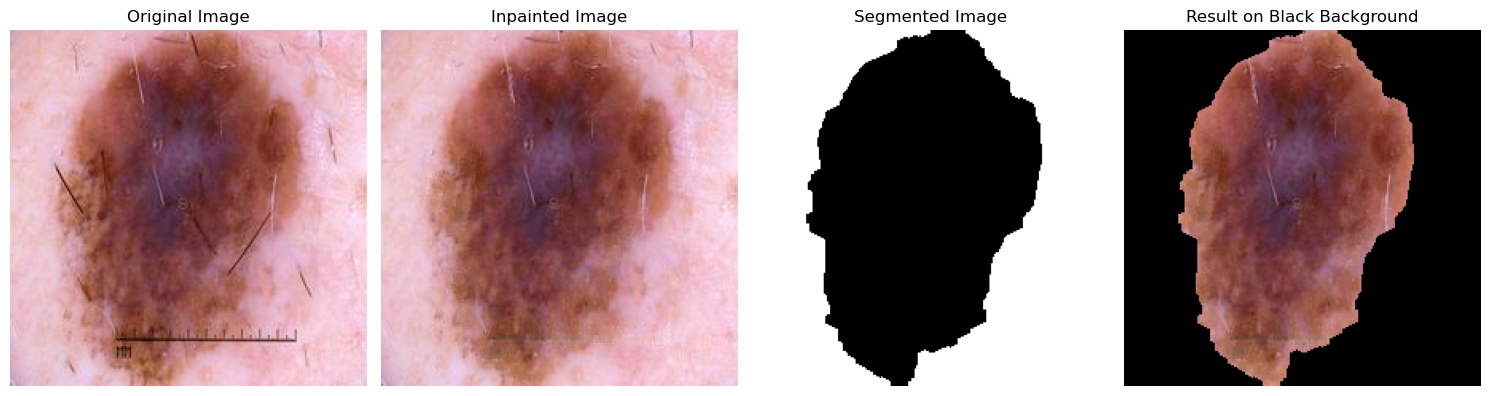

In [218]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def remove_small_components(image, threshold):
    # find all your connected components (white blobs in your image)
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=8)
    sizes = stats[1:, -1]
    nb_components = nb_components - 1
    img2 = np.zeros((output.shape), dtype=np.uint8)
    component_areas = []
    # for every component in the image, you keep it only if it's above threshold
    for i in range(0, nb_components):
        if sizes[i] >= threshold:
            img2[output == i + 1] = 255
            component_areas.append(sizes[i])
    return img2, component_areas

def remove_hair_and_segment(image_path):
    
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))  # Adjusted kernel size for better hair removal
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    _, mask1 = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(mask1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        if cv2.contourArea(contour) < 20:
            cv2.drawContours(mask1, [contour], -1, 0, -1)

    inverse_mask1 = cv2.bitwise_not(mask1)
    result_image = cv2.bitwise_and(image, image, mask=inverse_mask1)
    
    inpainted_image = cv2.inpaint(result_image, mask1, inpaintRadius=1, flags=cv2.INPAINT_TELEA)  
    
    gray_inpainted = cv2.cvtColor(inpainted_image, cv2.COLOR_BGR2GRAY)
    _, segmented_image = cv2.threshold(gray_inpainted, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    segmented_image, component_areas = remove_small_components(segmented_image, 300)  
   
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    segmented_image = cv2.morphologyEx(segmented_image, cv2.MORPH_OPEN, kernel, iterations=2)
    segmented_image = cv2.morphologyEx(segmented_image, cv2.MORPH_CLOSE, kernel, iterations=2)

    black_background = np.zeros_like(image)
    black_background[segmented_image < 255] = inpainted_image[segmented_image < 255]

    print("Areas of connected components:", component_areas)
    
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 4, 1)
    plt.title('Original Image')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.title('Inpainted Image')
    plt.imshow(cv2.cvtColor(inpainted_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.title('Segmented Image')
    plt.imshow(segmented_image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.title('Result on Black Background')
    plt.imshow(cv2.cvtColor(black_background, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.tight_layout()
    plt.show()


remove_hair_and_segment('data/train/Malignant/68.jpg')

Areas of connected components: [39559]


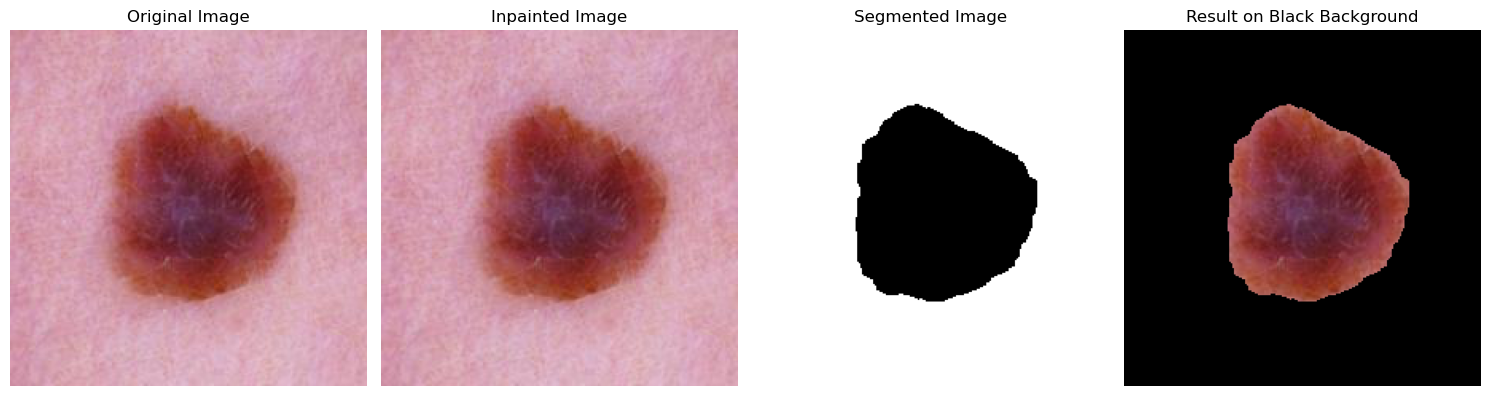

In [219]:
remove_hair_and_segment("/home/cloudcorn/sameerah/my_exam/detect-malignant/train-study_diff_between_data/malignant_clusters/cluster_0/15.jpg")

Areas of connected components: [45638]


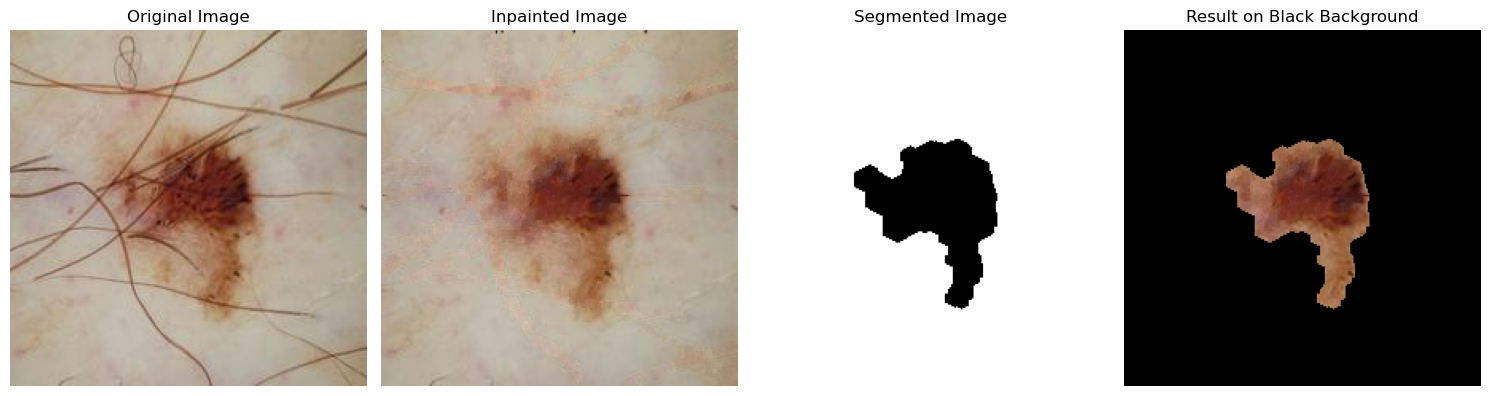

In [192]:
remove_hair_and_segment('data/train/Malignant/513.jpg')

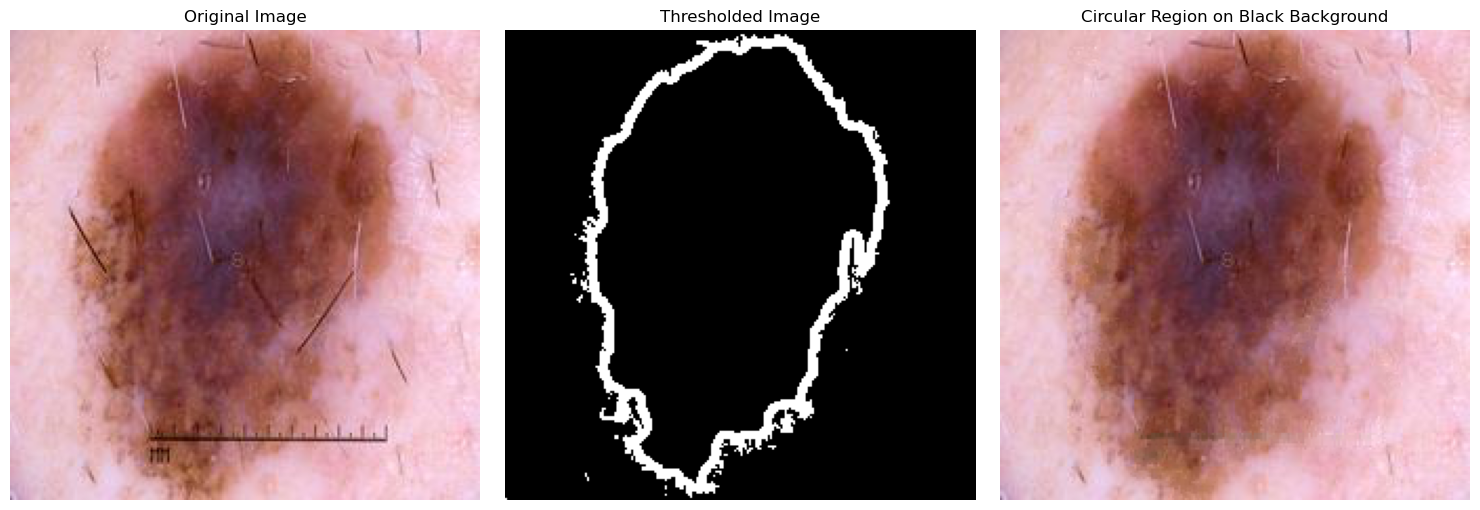

In [260]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def remove_small_components(image, threshold):
    # find all your connected components (white blobs in your image)
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=8)
    sizes = stats[1:, -1]
    nb_components = nb_components - 1
    img2 = np.zeros((output.shape), dtype=np.uint8)
    component_areas = []
    # for every component in the image, you keep it only if it's above threshold
    for i in range(0, nb_components):
        if sizes[i] >= threshold:
            img2[output == i + 1] = 255
            component_areas.append(sizes[i])
    return img2, component_areas

def remove_hair_and_segment(image_path):
    
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    _, mask1 = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(mask1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        if cv2.contourArea(contour) < 30:
            cv2.drawContours(mask1, [contour], -1, 0, -1)

    inverse_mask1 = cv2.bitwise_not(mask1)
    result_image = cv2.bitwise_and(image, image, mask=inverse_mask1)
    
    inpainted_image = cv2.inpaint(result_image, mask1, inpaintRadius=1, flags=cv2.INPAINT_TELEA)
    
    gray_inpainted = cv2.cvtColor(inpainted_image, cv2.COLOR_BGR2GRAY)
    _, segmented_image = cv2.threshold(gray_inpainted, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    segmented_image, component_areas = remove_small_components(segmented_image, 500)
    thresh = cv2.adaptiveThreshold(segmented_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)    
    # Find contours in the segmented image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Find the largest contour and compute the bounding rectangle
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        center = (x + w // 2, y + h // 2)

      
       
        scale_factor = 1.5
        radius = int(max(w, h) // 2 * scale_factor)

       
        mask = np.zeros_like(gray)
        cv2.circle(mask, center, radius, (255), thickness=-1)

        
        masked_image = cv2.bitwise_and(inpainted_image, inpainted_image, mask=mask)

        
        black_background = np.zeros_like(image)
        black_background[mask == 255] = masked_image[mask == 255]

        
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.title('Original Image')
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title('Thresholded Image')
        plt.imshow(thresh, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title('Circular Region on Black Background')
        plt.imshow(cv2.cvtColor(black_background, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.tight_layout()
        plt.show()


remove_hair_and_segment('data/train/Malignant/68.jpg')

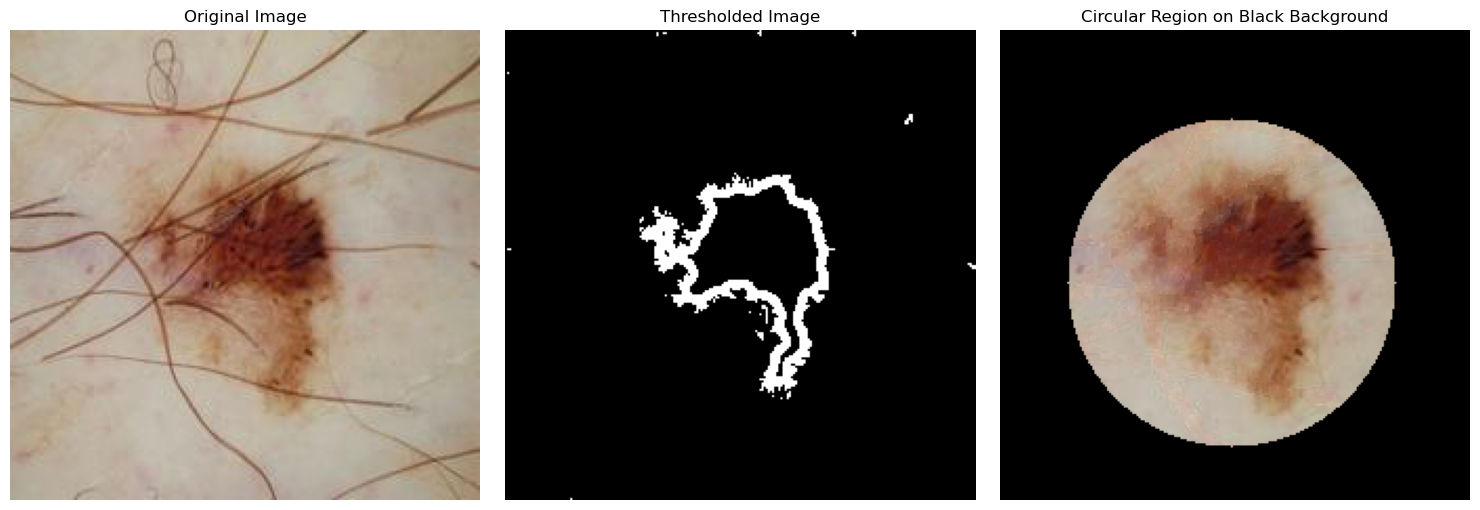

In [261]:
remove_hair_and_segment('data/train/Malignant/513.jpg')

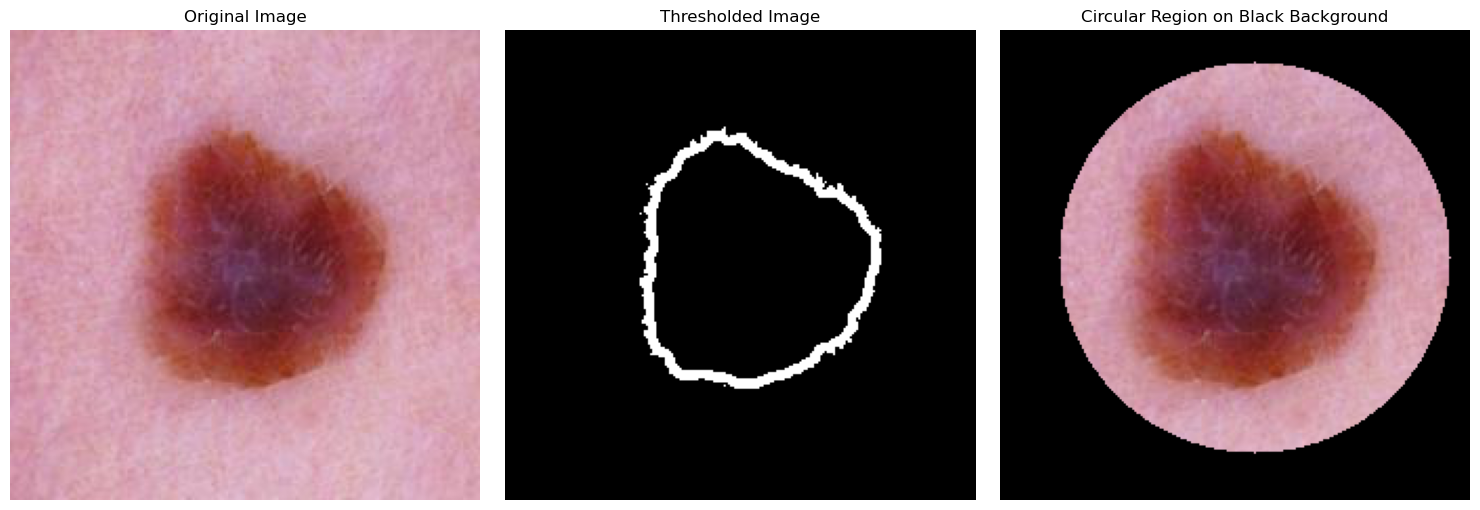

In [262]:
remove_hair_and_segment("/home/cloudcorn/sameerah/my_exam/detect-malignant/train-study_diff_between_data/malignant_clusters/cluster_0/15.jpg")

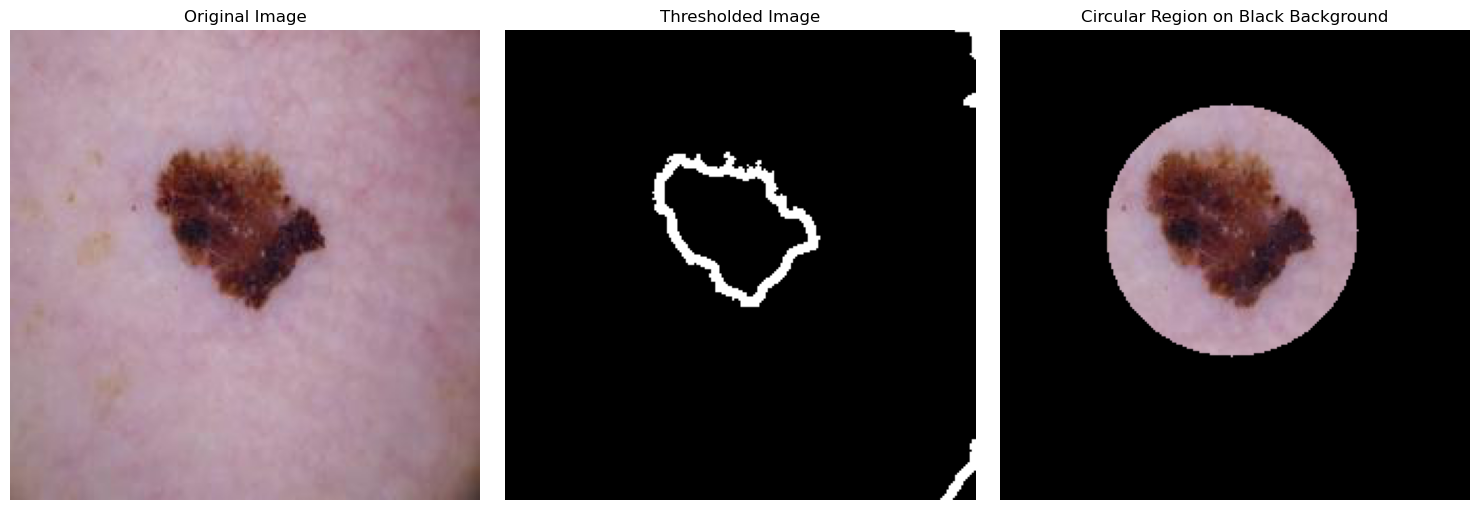

In [263]:
remove_hair_and_segment("/home/cloudcorn/sameerah/my_exam/detect-malignant/train-study_diff_between_data/malignant_clusters/cluster_1/127.jpg")

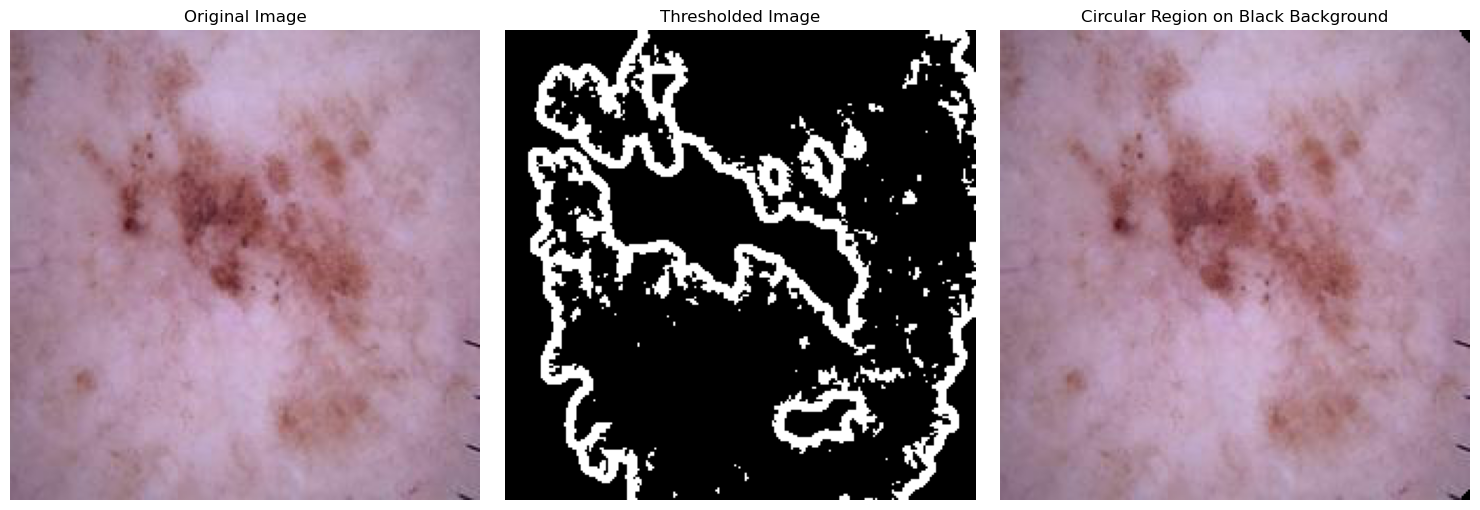

In [264]:
remove_hair_and_segment("/home/cloudcorn/sameerah/my_exam/detect-malignant/train-study_diff_between_data/malignant_clusters/cluster_1/189.jpg")

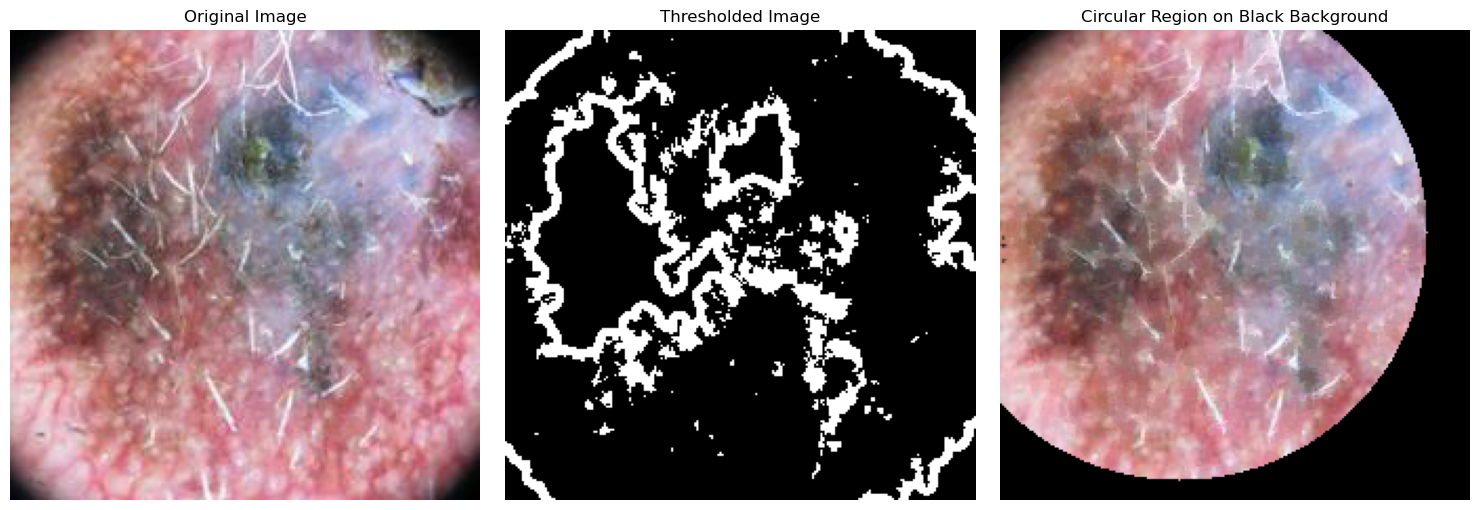

In [265]:
remove_hair_and_segment("/home/cloudcorn/sameerah/my_exam/detect-malignant/train-study_diff_between_data/malignant_clusters/cluster_1/5596.jpg")

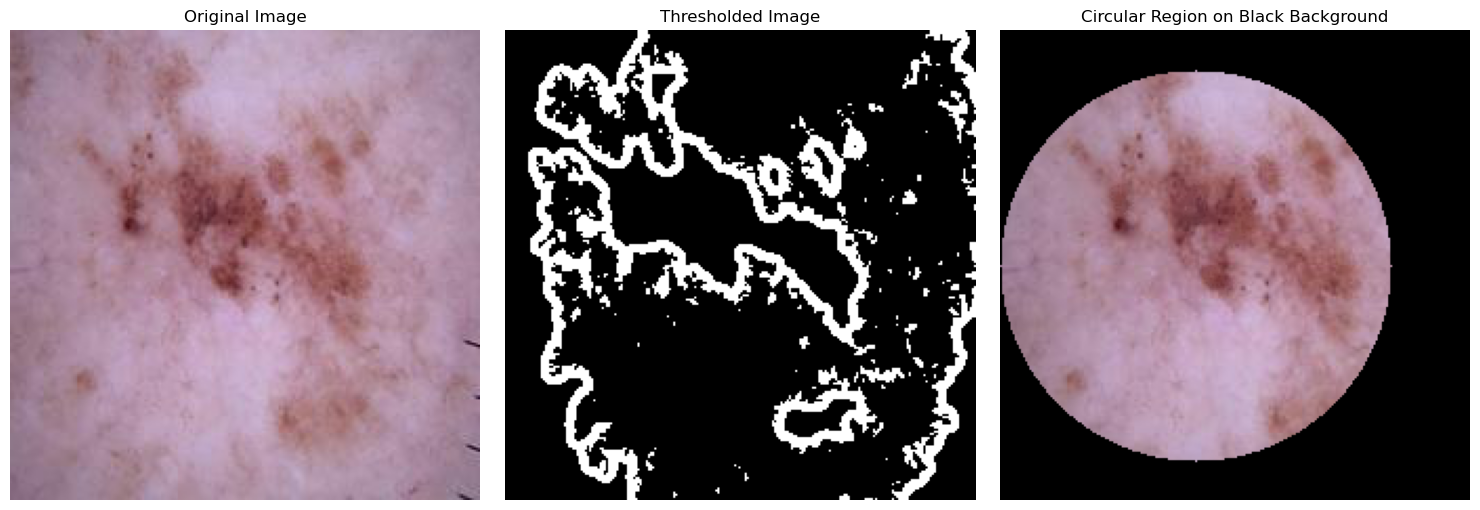

In [266]:
"""
ensures that the radius is not greater than the distance from the center to any edge of 
the image. This guarantees that the circular region will always fit within the image boundaries

"""

import cv2
import numpy as np
import matplotlib.pyplot as plt

def remove_small_components(image, threshold):
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=8)
    sizes = stats[1:, -1]
    nb_components = nb_components - 1
    img2 = np.zeros((output.shape), dtype=np.uint8)
    component_areas = []
    for i in range(0, nb_components):
        if sizes[i] >= threshold:
            img2[output == i + 1] = 255
            component_areas.append(sizes[i])
    return img2, component_areas

def remove_hair_and_segment(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    _, mask1 = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(mask1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        if cv2.contourArea(contour) < 30:
            cv2.drawContours(mask1, [contour], -1, 0, -1)

    inverse_mask1 = cv2.bitwise_not(mask1)
    result_image = cv2.bitwise_and(image, image, mask=inverse_mask1)
    
    inpainted_image = cv2.inpaint(result_image, mask1, inpaintRadius=1, flags=cv2.INPAINT_TELEA)
    
    gray_inpainted = cv2.cvtColor(inpainted_image, cv2.COLOR_BGR2GRAY)
    _, segmented_image = cv2.threshold(gray_inpainted, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    segmented_image, component_areas = remove_small_components(segmented_image, 500)
    thresh = cv2.adaptiveThreshold(segmented_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)    
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        center = (x + w // 2, y + h // 2)

        scale_factor = 1.5
        radius = int(max(w, h) // 2 * scale_factor)
        
        # Constrain the radius to be within the image dimensions
        radius = min(radius, center[0], center[1], image.shape[1] - center[0], image.shape[0] - center[1])
       
        mask = np.zeros_like(gray)
        cv2.circle(mask, center, radius, (255), thickness=-1)
        
        masked_image = cv2.bitwise_and(inpainted_image, inpainted_image, mask=mask)

        black_background = np.zeros_like(image)
        black_background[mask == 255] = masked_image[mask == 255]

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.title('Original Image')
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title('Thresholded Image')
        plt.imshow(thresh, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title('Circular Region on Black Background')
        plt.imshow(cv2.cvtColor(black_background, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.tight_layout()
        plt.show()

# Test the updated function with the provided image
remove_hair_and_segment("/home/cloudcorn/sameerah/my_exam/detect-malignant/train-study_diff_between_data/malignant_clusters/cluster_1/189.jpg")


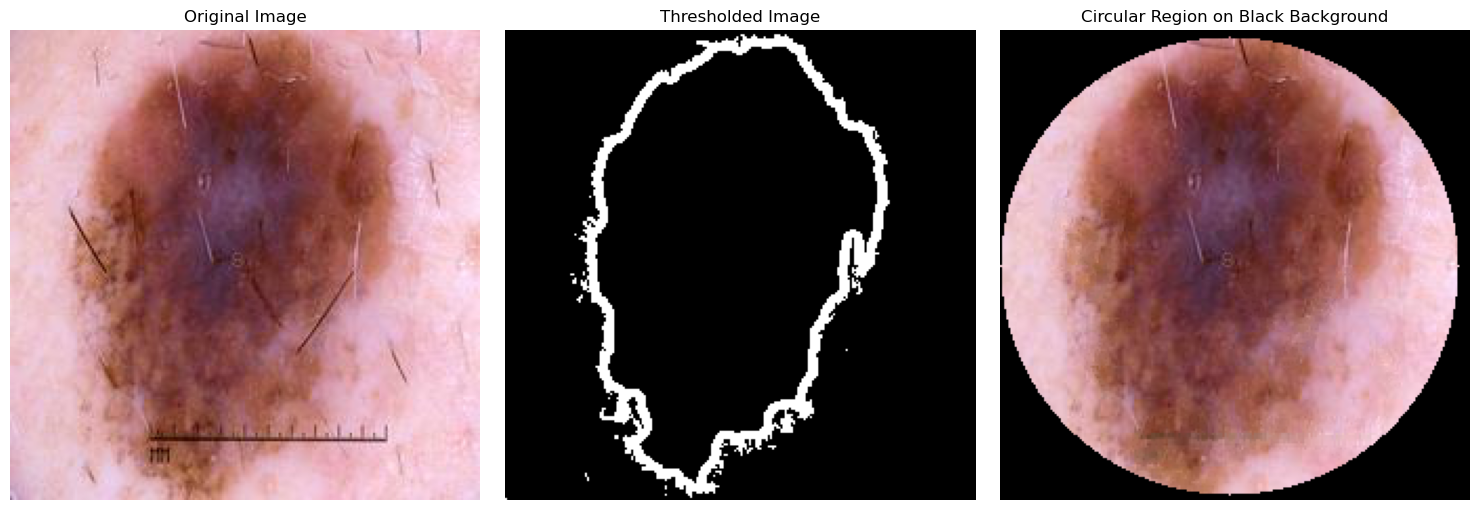

In [267]:
remove_hair_and_segment('data/train/Malignant/68.jpg')

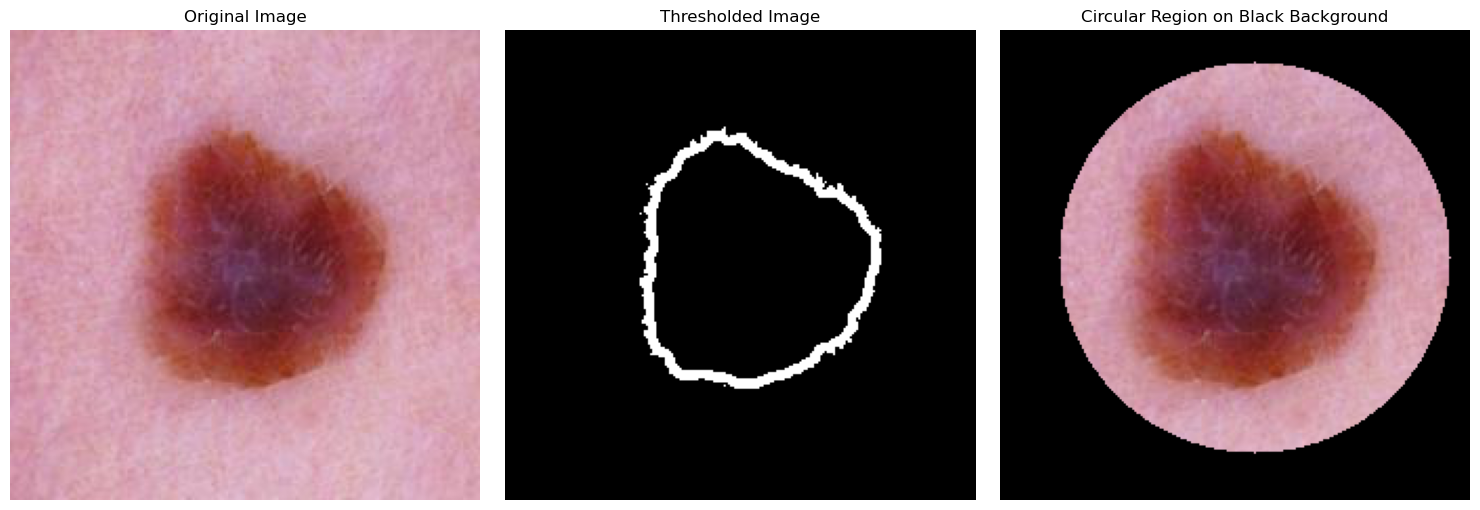

In [268]:
remove_hair_and_segment("/home/cloudcorn/sameerah/my_exam/detect-malignant/train-study_diff_between_data/malignant_clusters/cluster_0/15.jpg")

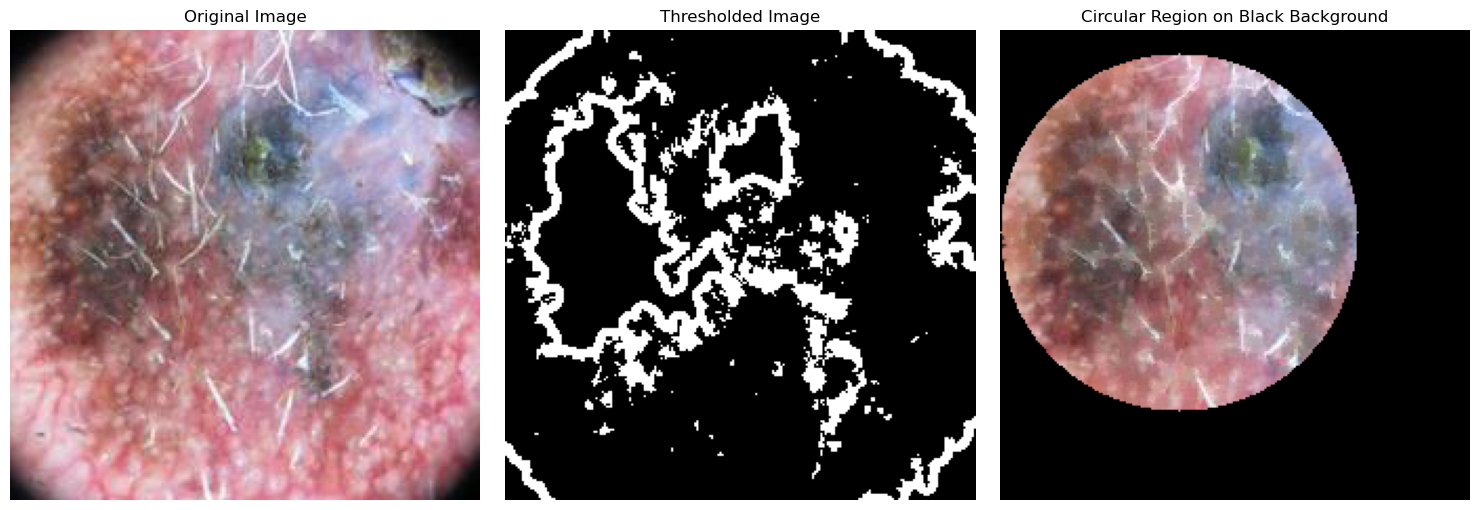

In [269]:
remove_hair_and_segment("/home/cloudcorn/sameerah/my_exam/detect-malignant/train-study_diff_between_data/malignant_clusters/cluster_1/5596.jpg")